In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import vaex

from matplotlib.lines import Line2D

sns.set(style='ticks', 
        rc={'font.family'          : 'serif',
            'text.usetex'          : True,
            'axes.axisbelow'       : True,
            'mathtext.fontset'     : 'cm',
            'mathtext.default'     : 'regular',
            'xtick.direction'      : 'in',
            'ytick.direction'      : 'in',
            'xtick.major.width'    : 1.1,
            'ytick.major.width'    : 1.1,
            'axes.labelpad'        : 5.0,
            'legend.framealpha'    : 0.95,
            'legend.handlelength'  : 1.2,
            'legend.handletextpad' : 0.5,
       })

pal = sns.color_palette('colorblind')
dark = sns.color_palette('dark')
sns.set_palette(pal)

In [2]:
def open_and_select(photfile='../legacy_phot/M33_full_unmatched.hdf5'):
    if type(photfile) == list:
        ds = vaex.open_many(photfile)
    else:
        ds = vaex.open(photfile)
    ds.select('(F275W_SNR > 4) & (F275W_SHARP**2 < 0.15)', name='F275W_ST')
    ds.select('(F275W_ST & (F275W_CROWD < 1.30))', name='F275W_GST')
    ds.select('(F336W_SNR > 4) & (F336W_SHARP**2 < 0.15)', name='F336W_ST')
    ds.select('F336W_ST & (F336W_CROWD < 1.30)', name='F336W_GST')
    ds.select('F275W_ST | F336W_ST', name='UV_ST')
    ds.select('F275W_GST & F336W_GST', name='UV_GST')

    ds.select('(F475W_SNR > 4) & (F475W_SHARP**2 < 0.2)', name='F475W_ST')
    ds.select('(F475W_ST & (F475W_CROWD < 2.25))', name='F475W_GST')
    ds.select('(F814W_SNR > 4) & (F814W_SHARP**2 < 0.2)', name='F814W_ST')
    ds.select('F814W_ST & (F814W_CROWD < 2.25)', name='F814W_GST')
    ds.select('F475W_ST | F814W_ST', name='OPT_ST')
    ds.select('F475W_GST & F814W_GST', name='OPT_GST')

    ds.select('(F110W_SNR > 4) & (F110W_SHARP**2 < 0.15)', name='F110W_ST')
    ds.select('F110W_ST & (F110W_CROWD < 2.25)', name='F110W_GST')
    ds.select('(F160W_SNR > 4) & (F160W_SHARP**2 < 0.15)', name='F160W_ST')
    ds.select('F160W_ST & (F160W_CROWD < 2.25)', name='F160W_GST')
    ds.select('F110W_ST | F160W_ST', name='IR_ST')
    ds.select('F110W_GST & F160W_GST', name='IR_GST')
    return ds

ds = open_and_select()
print(ds.length())

22549213


In [3]:
def add_colorbar(fig, ax, cmap='viridis', vmin=0, vmax=1,
                 norm='Normalize', n_colors=None,
                 offset=0.0175, width=0.0225, label='Density'):
    pos = ax.get_position()
    cax = fig.add_axes([pos.x1+offset, pos.y0, width, pos.height])
    cmap_mpl = plt.get_cmap(cmap, n_colors)
    norm_mpl = getattr(mpl.colors, norm)(vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm_mpl, cmap=cmap_mpl),
                        cax=cax, label=label)
    return cbar

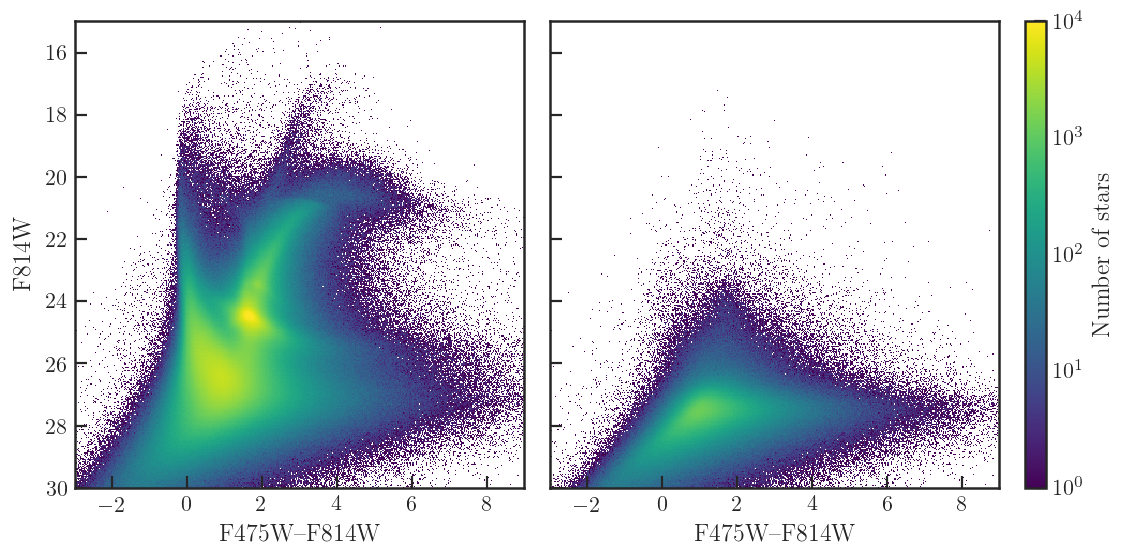

In [4]:
# W14 Fig 7

colormap, vmin, vmax = 'viridis', 1, 1e4
cmap = getattr(mpl.cm, colormap)
norm = mpl.colors.LogNorm(vmin=vmin, vmax=vmax)

opt_lim = [[-3, 9], [30, 15]]

fig = plt.figure(figsize=(7.2, 4))
ds.plot('F475W_VEGA-F814W_VEGA', 'F814W_VEGA', limits=opt_lim,
        f='log10', colorbar=False, colormap=colormap,
        vmin=np.log10(vmin), vmax=np.log10(vmax), interpolation='None', shape=420,
        selection=[None, '~OPT_ST'], visual=dict(column='selection'),
        xlabel='F475W--F814W', ylabel='F814W')
ax0, ax1 = fig.get_axes()
ax1.set_ylabel(None)
ax1.set_yticklabels([])
fig.tight_layout()

pos = ax1.get_position()
cax = fig.add_axes([pos.x1+0.025, pos.y0, 0.02, pos.height])
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), cax=cax, label='Number of stars')

fig.savefig('survey_paper_figures/F475W_F814W_full_cut_CMDs.pdf', dpi=420, bbox_inches='tight')

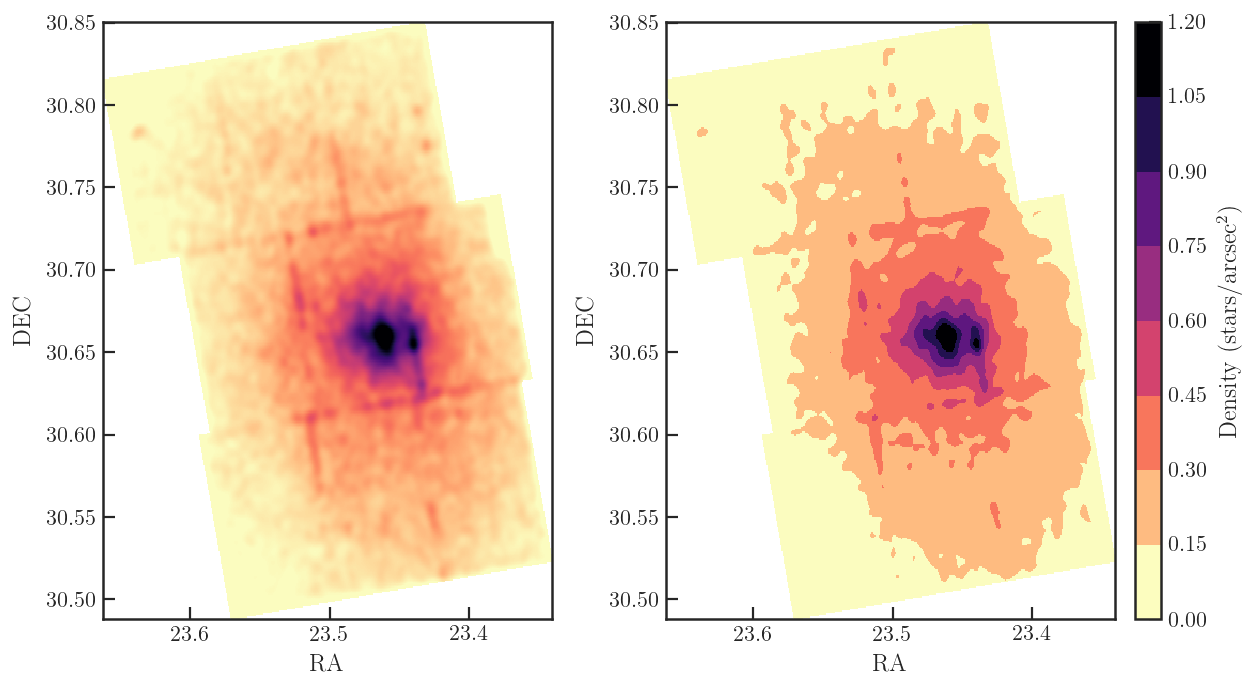

In [5]:
# W14 Fig 10
cmap, ncolors = 'magma_r', 8
ds.plot('RA','DEC', what=['mean(DENSITY)', 'mean(DENSITY)'], limits='minmax', shape=420, 
        colormap=[cmap, plt.get_cmap(cmap, ncolors)], vmin=[0.075, 0], vmax=[1.125, 1.2],
        colorbar=False, figsize=(8,6), interpolation='None')
fig = plt.gcf()
for ax in fig.get_axes():
    ax.invert_xaxis()
ax = plt.gca()
cbar = add_colorbar(fig, ax, cmap=cmap, vmax=1.2, n_colors=ncolors,
                    label='Density (stars/arcsec$^2$)')
cbar.set_ticks(np.round(np.arange(0, 1.3, 0.15), 2))

fig.savefig('survey_paper_figures/density_map.pdf', dpi=300, bbox_inches='tight')

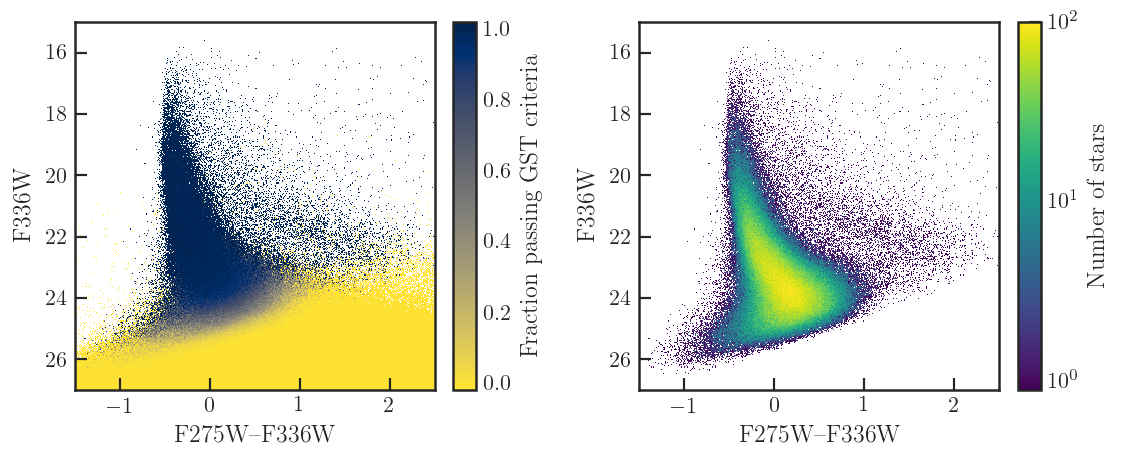

In [6]:
# W14 Fig 9
ds.plot('F275W_VEGA-F336W_VEGA', 'F336W_VEGA', figsize=(7.2, 4), 
        limits=[[-1.5, 2.5], [27, 15]], shape=360, colorbar=False,
        f=[None, 'log10'], colormap=['cividis_r', 'viridis'],
        vmin=[-0.02, np.log10(0.9)], vmax=[1.02, np.log10(1e2)],
        what=['mean(F275W_GST_FLAG*F336W_GST_FLAG)',
              'sum(F275W_GST_FLAG*F336W_GST_FLAG)'],
        xlabel='F275W--F336W', ylabel='F336W')

fig = plt.gcf()
fig.tight_layout(w_pad=6)

axes = fig.get_axes()

add_colorbar(fig, axes[0], cmap='cividis_r', vmin=-0.02, vmax=1.02,
             norm='Normalize', label='Fraction passing GST criteria')
add_colorbar(fig, axes[1], cmap='viridis', vmin=0.9, vmax=1e2,
             norm='LogNorm', label='Number of stars')

fig.savefig('survey_paper_figures/F275W_F336W_CMDs.pdf', dpi=420, bbox_inches='tight')


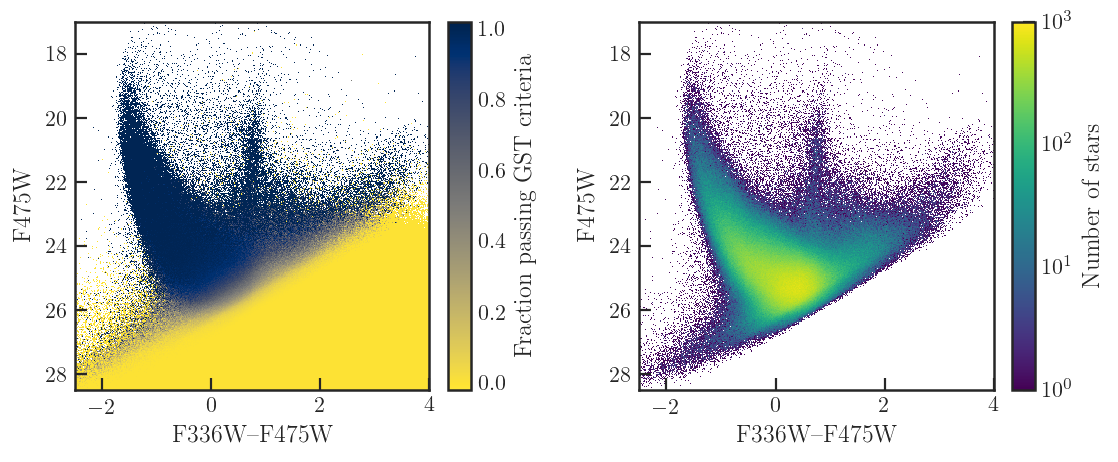

In [7]:
# W14 Fig 11-12
ds.plot('F336W_VEGA-F475W_VEGA', 'F475W_VEGA', figsize=(7.2, 4), 
        limits=[[-2.5, 4], [28.5, 17]], shape=360, colorbar=False,
        f=[None, 'log10'], colormap=['cividis_r', 'viridis'],
        vmin=[-0.02, np.log10(0.9)], vmax=[1.02, np.log10(5e2)],
        what=['mean(F336W_GST_FLAG*F475W_GST_FLAG)',
              'sum(F336W_GST_FLAG*F475W_GST_FLAG)'],
        xlabel='F336W--F475W', ylabel='F475W')

fig = plt.gcf()
fig.tight_layout(w_pad=6)

axes = fig.get_axes()

add_colorbar(fig, axes[0], cmap='cividis_r', vmin=-0.02, vmax=1.02,
             norm='Normalize', label='Fraction passing GST criteria')
add_colorbar(fig, axes[1], cmap='viridis', vmin=1, vmax=1e3,
             norm='LogNorm', label='Number of stars')

fig.savefig('survey_paper_figures/F336W_F475W_CMDs.pdf', dpi=420, bbox_inches='tight')


In [8]:
density_tuples = [(0, 0.15), (0.15, 0.3), (0.3, 0.6), (0.6, 1.5)]
selections = [f'(DENSITY >= {d0}) & (DENSITY < {d1})' for d0, d1 in density_tuples]
n = len(density_tuples)

/astro/users/mdurbin/miniconda3/envs/astroconda/lib/python3.7/site-packages/vaex/viz/mpl.py:841: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  pylab.tight_layout()


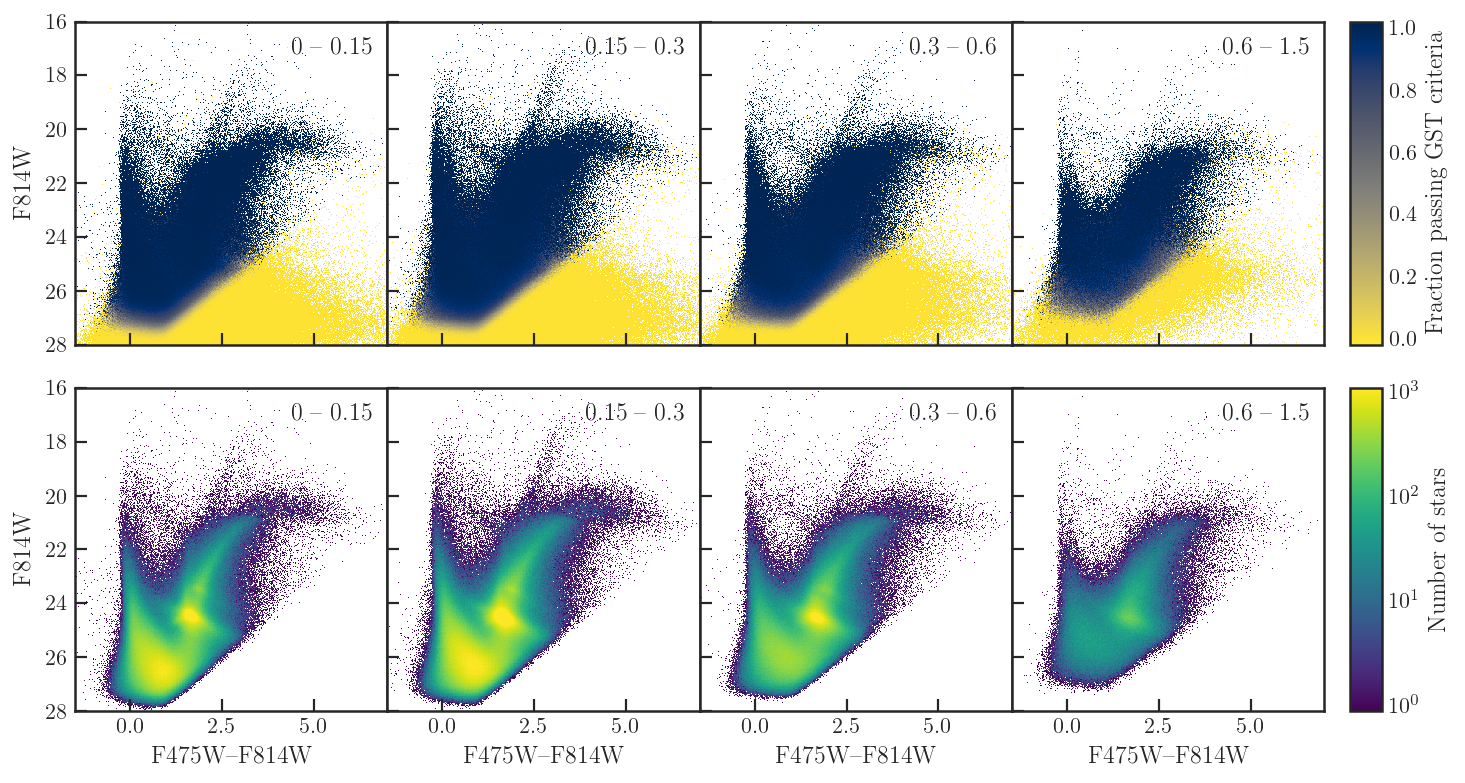

In [9]:
# W14 Fig 13-14
ds.plot('F475W_VEGA-F814W_VEGA', 'F814W_VEGA', figsize=(10, 5.6), 
        limits=[[-1.5, 7], [28, 16]], shape=420, colorbar=False,
        f=[None, 'log10'], colormap=['cividis_r', 'viridis'],
        vmin=[-0.02, np.log10(0.9)], vmax=[1.02, np.log10(1.1e3)],
        what=['mean(F475W_GST_FLAG*F814W_GST_FLAG)',
              f'sum(F475W_GST_FLAG*F814W_GST_FLAG)'],
        selection=selections,
        visual=dict(row='what', column='selection'),
        xlabel='F475W--F814W', ylabel='F814W')

fig = plt.gcf()
axes = fig.get_axes()

for ax in axes[1:n] + axes[(n+1):]:
    ax.set_ylabel(None)
    ax.set_yticklabels([])
for ax in axes[:-n]:
    ax.set_xlabel(None)
    ax.set_xticklabels([])

for i, (d0, d1) in enumerate(density_tuples):
    for ax in axes[0+i:(n+1)+i:n]:
        ax.text(0.95, 0.95, f'{d0} -- {d1}',
                ha='right', va='top', transform=ax.transAxes)

fig.tight_layout(w_pad=0, h_pad=1)

add_colorbar(fig, axes[-(n+1)], cmap='cividis_r', vmin=-0.02, vmax=1.02,
             norm='Normalize', label='Fraction passing GST criteria')
add_colorbar(fig, axes[-1], cmap='viridis', vmin=0.9, vmax=1.1e3,
             norm='LogNorm', label='Number of stars')

fig.savefig('survey_paper_figures/F475W_F814W_CMDs.pdf', dpi=420, bbox_inches='tight')


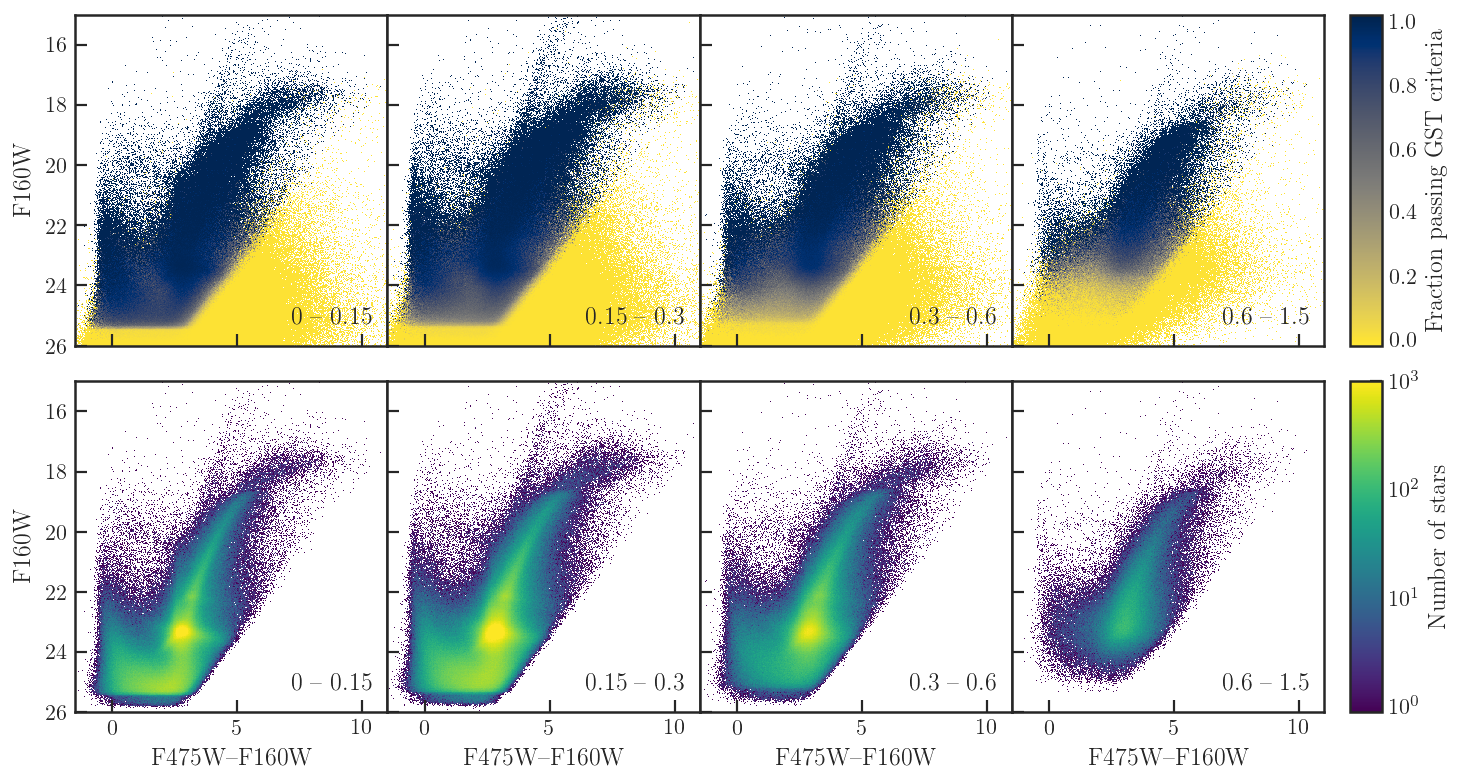

In [10]:
# W14 Fig 15-16
ds.plot('F475W_VEGA-F160W_VEGA', 'F160W_VEGA', figsize=(10, 5.6), 
        limits=[[-1.5, 11], [26, 15]], shape=420, colorbar=False,
        f=[None, 'log10'], colormap=['cividis_r', 'viridis'],
        vmin=[-0.02, np.log10(0.9)], vmax=[1.02, np.log10(1e3)],
        what=['mean(F475W_GST_FLAG*F160W_GST_FLAG)',
              'sum(F475W_GST_FLAG*F160W_GST_FLAG)'],
        selection=selections,
        visual=dict(row='what', column='selection'),
        xlabel='F475W--F160W', ylabel='F160W')

fig = plt.gcf()
axes = fig.get_axes()

for ax in axes[1:n] + axes[(n+1):]:
    ax.set_ylabel(None)
    ax.set_yticklabels([])
for ax in axes[:-n]:
    ax.set_xlabel(None)
    ax.set_xticklabels([])

for i, (d0, d1) in enumerate(density_tuples):
    for ax in axes[0+i:(n+1)+i:n]:
        ax.text(0.95, 0.05, f'{d0} -- {d1}',
                ha='right', va='bottom', transform=ax.transAxes)

fig.tight_layout(w_pad=0, h_pad=1)

add_colorbar(fig, axes[-(n+1)], cmap='cividis_r', vmin=-0.02, vmax=1.02,
             norm='Normalize', label='Fraction passing GST criteria')
add_colorbar(fig, axes[-1], cmap='viridis', vmin=0.9, vmax=1e3,
             norm='LogNorm', label='Number of stars')

fig.savefig('survey_paper_figures/F475W_F160W_CMDs.pdf', dpi=420, bbox_inches='tight')


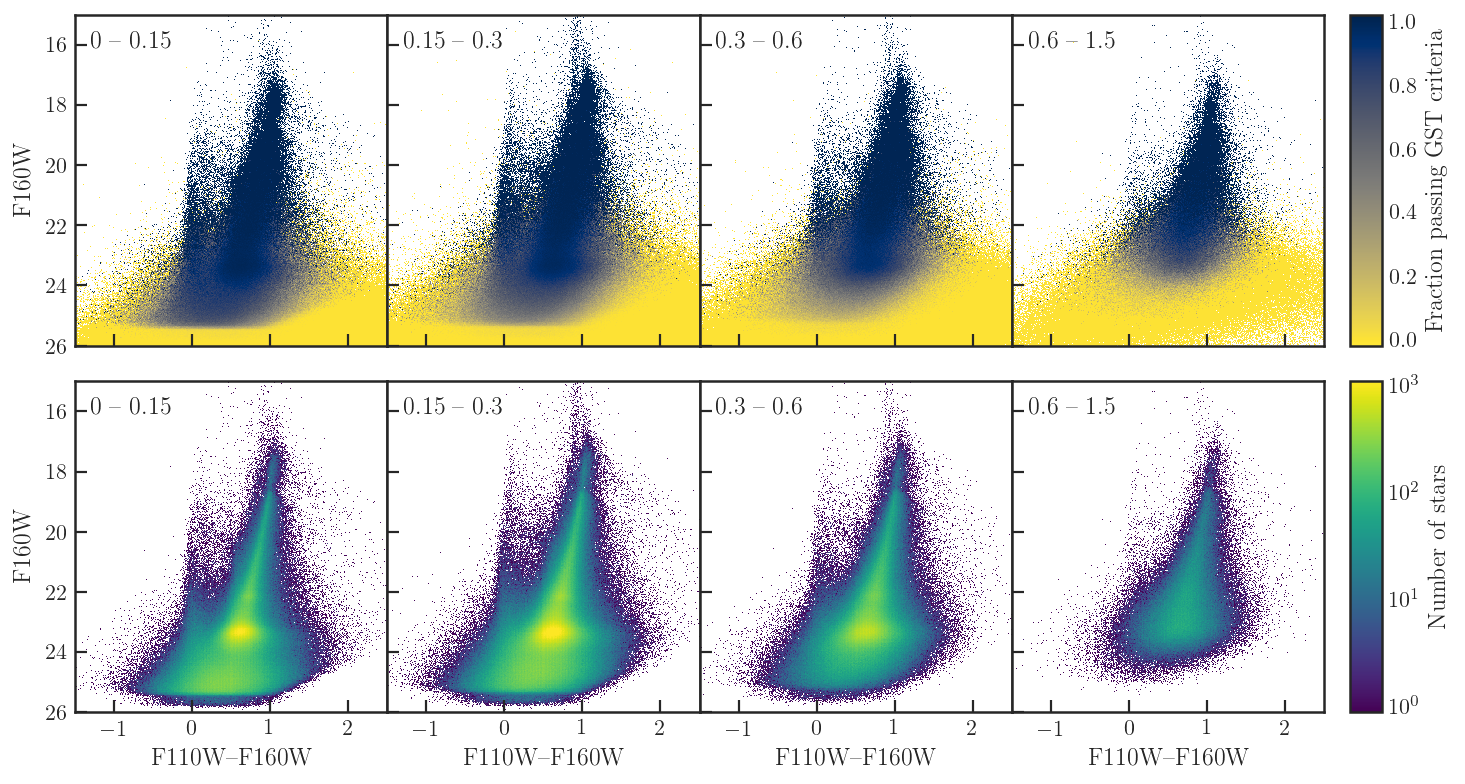

In [11]:
# W14 Fig 17-18
ds.plot('F110W_VEGA-F160W_VEGA', 'F160W_VEGA', figsize=(10, 5.6), 
        limits=[[-1.5, 2.5], [26, 15]], shape=420, colorbar=False,
        f=[None, 'log10'], colormap=['cividis_r', 'viridis'],
        vmin=[-0.02, np.log10(0.9)], vmax=[1.02, np.log10(1.1e3)],
        what=['mean(F110W_GST_FLAG*F160W_GST_FLAG)',
              'sum(F110W_GST_FLAG*F160W_GST_FLAG)'],
        selection=selections,
        visual=dict(row='what', column='selection'),
        xlabel='F110W--F160W', ylabel='F160W')

fig = plt.gcf()
axes = fig.get_axes()

for ax in axes[1:n] + axes[(n+1):]:
    ax.set_ylabel(None)
    ax.set_yticklabels([])
for ax in axes[:-n]:
    ax.set_xlabel(None)
    ax.set_xticklabels([])

for i, (d0, d1) in enumerate(density_tuples):
    for ax in axes[0+i:(n+1)+i:n]:
        ax.text(0.05, 0.95, f'{d0} -- {d1}',
                ha='left', va='top', transform=ax.transAxes)

fig.tight_layout(w_pad=0, h_pad=1)

add_colorbar(fig, axes[-(n+1)], cmap='cividis_r', vmin=-0.02, vmax=1.02,
             norm='Normalize', label='Fraction passing GST criteria')
add_colorbar(fig, axes[-1], cmap='viridis', vmin=0.9, vmax=1.1e3,
             norm='LogNorm', label='Number of stars')

fig.savefig('survey_paper_figures/F110W_F160W_CMDs.pdf', dpi=420, bbox_inches='tight')


In [12]:
n_det = ds.evaluate('+'.join(ds.get_column_names(regex='F.*?W_GST_FLAG')))
if 'n_detected' in ds.get_column_names():
    ds.drop('n_detected', inplace=True)
ds.add_column('n_detected', n_det)

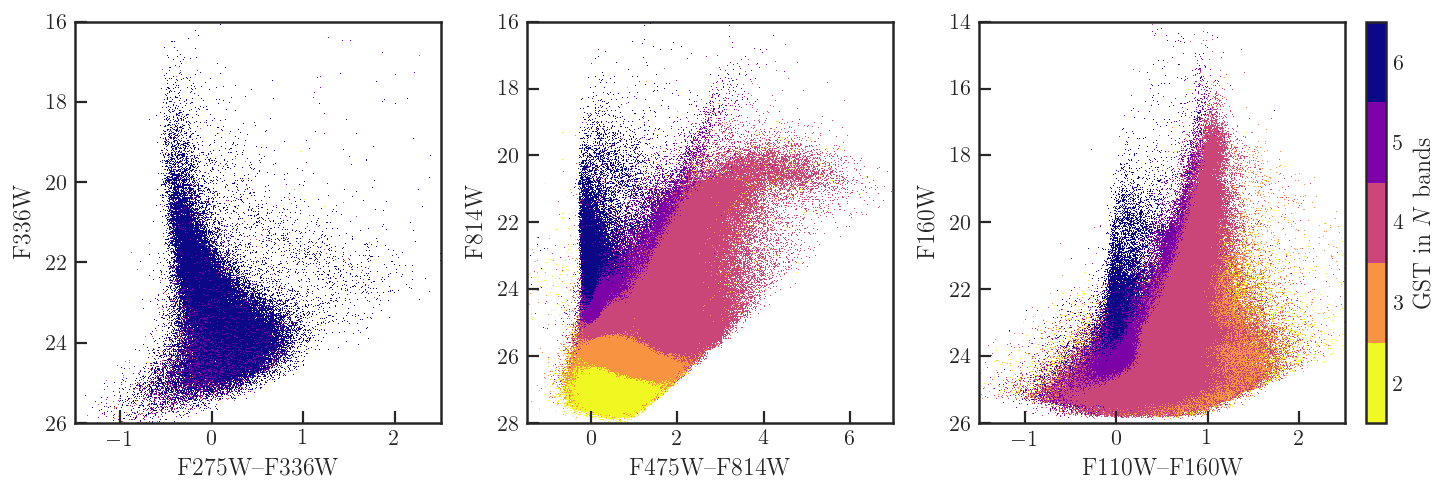

In [13]:
# W14 Fig 8

colormap_frac, vmin_frac, vmax_frac = plt.cm.get_cmap('plasma_r', 5), 1.5, 6.5
cmap_frac = colormap_frac #getattr(mpl.cm, colormap_frac)
norm_frac = mpl.colors.Normalize(vmin_frac, vmax_frac)

fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(9.6, 3.6))

plt.sca(ax0)
ds.plot('F275W_VEGA-F336W_VEGA', 'F336W_VEGA', limits=[[-1.5, 2.5], [26, 16]],
        colormap=colormap_frac, colorbar=False, what=f'mean(n_detected)',
        vmin=vmin_frac, vmax=vmax_frac, interpolation='None', shape=420,
        xlabel='F275W--F336W', ylabel='F336W', selection=['UV_GST & (DENSITY < 0.15)'])

plt.sca(ax1)
ds.plot('F475W_VEGA-F814W_VEGA', 'F814W_VEGA', limits=[[-1.5, 7], [28, 16]],
        colormap=colormap_frac, colorbar=False, what=f'mean(n_detected)',
        vmin=vmin_frac, vmax=vmax_frac, interpolation='None', shape=420,
        xlabel='F475W--F814W', ylabel='F814W', selection=['OPT_GST & (DENSITY < 0.15)'])

plt.sca(ax2)
ds.plot('F110W_VEGA-F160W_VEGA', 'F160W_VEGA', limits=[[-1.5, 2.5], [26, 14]],
        colormap=colormap_frac, colorbar=False, what=f'mean(n_detected)',
        vmin=vmin_frac, vmax=vmax_frac, interpolation='None', shape=420,
        xlabel='F110W--F160W', ylabel='F160W', selection=['IR_GST & (DENSITY < 0.15)'])

fig.tight_layout()

cbar = add_colorbar(fig, ax2, cmap='plasma_r', vmin=1.5, vmax=6.5,
                    norm='Normalize', n_colors=5,
                    offset=0.015, width=0.015, label='GST in $N$ bands')

fig.savefig('survey_paper_figures/nbands_cmds.pdf', dpi=420, bbox_inches='tight')


<string>:1: RuntimeWarning: invalid value encountered in greater
/astro/users/mdurbin/miniconda3/envs/astroconda/lib/python3.7/site-packages/vaex/image.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rgba_dest[:, :, c][[mask]] = np.clip(result[[mask]], 0, 1)


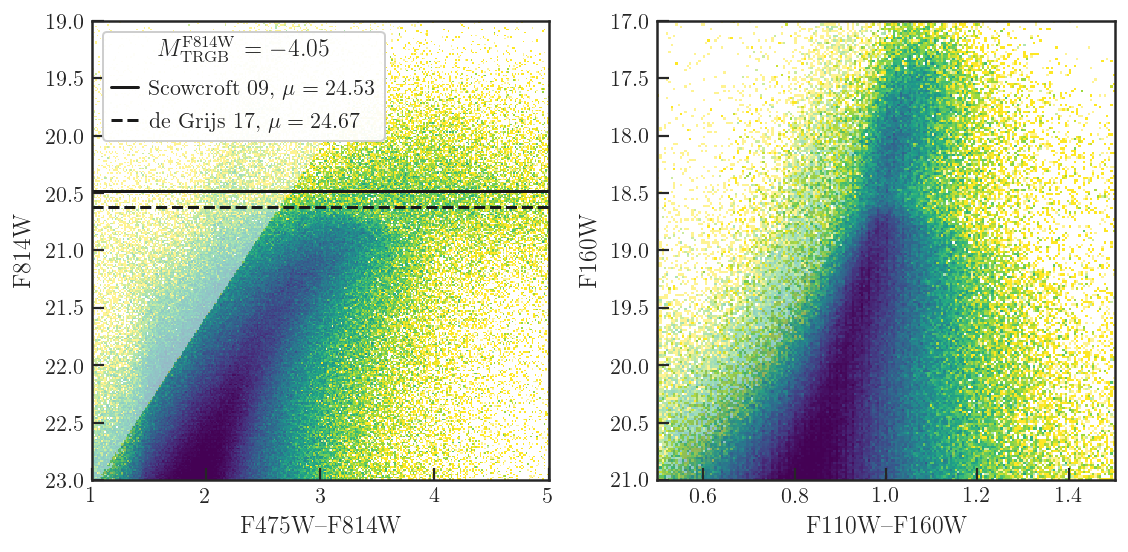

In [14]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

Mtrgb = -4.05
m, b = np.polyfit([1.5, 2.5], [22.5, 21.], 1)
good_rgb = f'(IR_ST & ~isfinite(F275W_VEGA) & (F814W_VEGA > {m}*(F475W_VEGA-F814W_VEGA)+{b}))'
ds.select(good_rgb, name='good_rgb')

plt.sca(ax1)
ds.plot('F475W_VEGA-F814W_VEGA-(0.135-0.063)', 'F814W_VEGA-0.063', limits=[[1, 5], [23, 19]],
        colormap='viridis_r', f='log10', colorbar=False,
        vmin=0, vmax=2, interpolation='None', shape=300,
        xlabel='F475W--F814W', ylabel='F814W', selection=['IR_ST','good_rgb'])
ax1.axhline(Mtrgb+24.53, color='k', label='Scowcroft 09, $\mu=24.53$')
ax1.axhline(Mtrgb+24.67, color='k', linestyle='--', label='de Grijs 17, $\mu=24.67$')
ax1.legend(title='$M^{\mathrm{F814W}}_{\mathrm{TRGB}} = '+f'{Mtrgb:.2f}$', loc='upper left')

plt.sca(ax2)
ds.plot('F110W_VEGA-F160W_VEGA', 'F160W_VEGA', limits=[[0.5, 1.5], [21, 17]],
        colormap='viridis_r', f='log10', colorbar=False,
        vmin=0, vmax=2, interpolation='None', shape=200,
        xlabel='F110W--F160W', ylabel='F160W', selection=['IR_ST','good_rgb'])

fig.tight_layout()



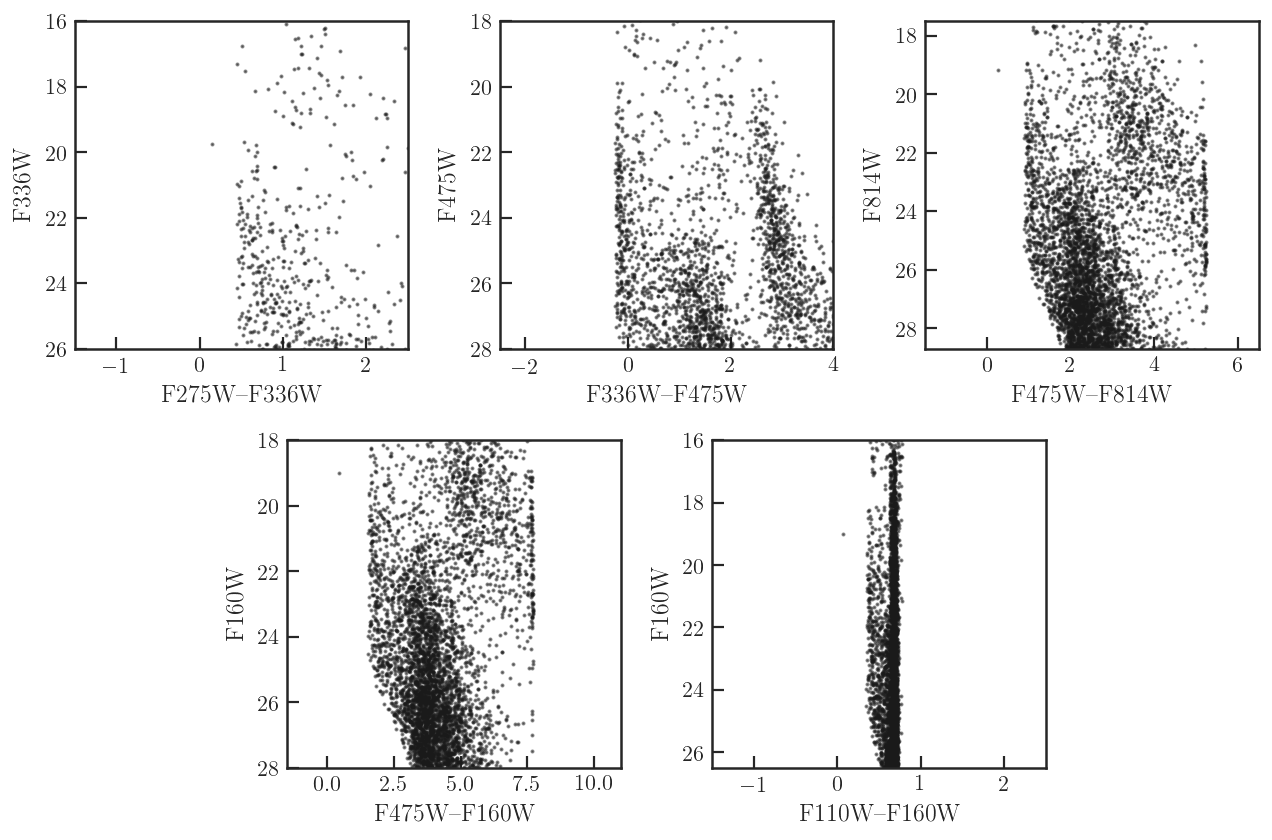

In [22]:
df = pd.read_csv('triout_m33_frg_260sqrarcmin.dat', delim_whitespace=True,
                 ).rename(columns=lambda x: x.replace('mag','').replace('W1','W'))

fig = plt.figure(figsize=(9,6))
gs = fig.add_gridspec(4, 6)

plot_kwargs = dict(s=1, color='k', alpha=0.5)

def add_ax(gs0, gs1, f_blue, f_red, x0, x1, y0, y1, plot_kwargs=plot_kwargs):
    ax = fig.add_subplot(gs[gs0, gs1])
    ax.scatter(df[f_blue]-df[f_red], df[f_red], **plot_kwargs)
    ax.set_xlim(x0, x1)
    ax.set_ylim(y0, y1)
    ax.set_xlabel(f'{f_blue}--{f_red}')
    ax.set_ylabel(f_red)

add_ax(slice(0,2), slice(0,2), 'F275W', 'F336W', -1.5, 2.5, 26,   16)
add_ax(slice(0,2), slice(2,4), 'F336W', 'F475W', *[-1.5, 2.5], *[27, 15])
add_ax(slice(0,2), slice(4,6), 'F475W', 'F814W', *[-1.5, 7  ], *[28, 16])
add_ax(slice(2,4), slice(1,3), 'F475W', 'F160W', *[-1.5, 11 ], *[26, 15])
add_ax(slice(2,4), slice(3,5), 'F110W', 'F160W', *[-1.5, 2.5], *[26, 15])

fig.tight_layout()
fig.savefig('survey_paper_figures/trilegal_foreground.pdf', dpi=420, bbox_inches='tight')

M33_B01_SE X: [2666 9480] Y: [ 6399 12198]
M33_B03_NN X: [ 6002 13016] Y: [ 8423 14214]


<string>:1: RuntimeWarning: invalid value encountered in greater


M33_B03_NE X: [2564 9626] Y: [ 8413 14202]


<string>:1: RuntimeWarning: invalid value encountered in greater


M33_B02_SS X: [ 5940 12954] Y: [ 6409 12196]


<string>:1: RuntimeWarning: invalid value encountered in greater


M33_B02_NE X: [ 5516 12576] Y: [ 8502 14288]


<string>:1: RuntimeWarning: invalid value encountered in greater


M33_B02_SW X: [ 6070 13132] Y: [ 6191 11979]


<string>:1: RuntimeWarning: invalid value encountered in greater


M33_B02_SE X: [3082 9890] Y: [ 6509 12294]


<string>:1: RuntimeWarning: invalid value encountered in greater


M33_B01_SW X: [ 5561 12625] Y: [ 6280 12081]


<string>:1: RuntimeWarning: invalid value encountered in greater


M33_B02_NN X: [ 6273 13279] Y: [ 8435 14222]


<string>:1: RuntimeWarning: invalid value encountered in greater


M33_B02_NW X: [ 5796 12596] Y: [ 8194 13982]


<string>:1: RuntimeWarning: invalid value encountered in greater


M33_B01_NE X: [2574 9640] Y: [ 8420 14220]


<string>:1: RuntimeWarning: invalid value encountered in greater


M33_B03_SS X: [ 5842 12858] Y: [2640 8430]


<string>:1: RuntimeWarning: invalid value encountered in greater


M33_B03_NW X: [ 5802 12612] Y: [ 8195 13987]


<string>:1: RuntimeWarning: invalid value encountered in greater


M33_B03_SW X: [ 5459 12523] Y: [2411 8203]


<string>:1: RuntimeWarning: invalid value encountered in greater


M33_B03_SE X: [2570 9378] Y: [2725 8514]


<string>:1: RuntimeWarning: invalid value encountered in greater


M33_B01_NW X: [ 5806 12606] Y: [ 8207 14010]


<string>:1: RuntimeWarning: invalid value encountered in greater


M33_B01_NN X: [ 6014 13020] Y: [ 8426 14227]


<string>:1: RuntimeWarning: invalid value encountered in greater


M33_B01_SS X: [ 6293 13305] Y: [ 6532 12333]


<string>:1: RuntimeWarning: invalid value encountered in greater


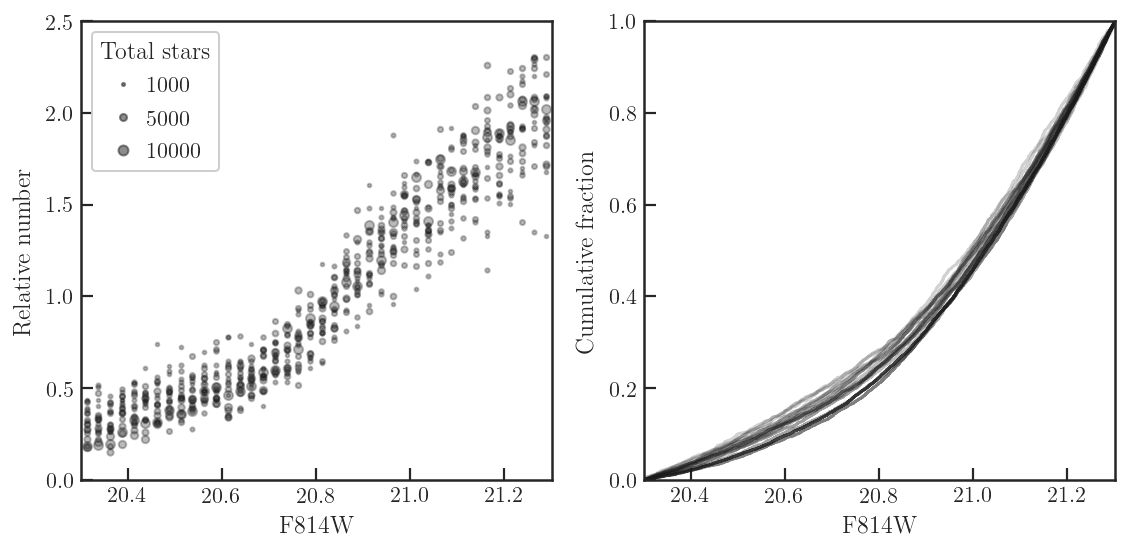

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True)

    
custom_lines = [Line2D([0], [0], marker='.', color='k', ms=1000**0.5/10, lw=0, label='1000', alpha=0.5),
                Line2D([0], [0], marker='.', color='k', ms=5000**0.5/10, lw=0, label='5000', alpha=0.5),
                Line2D([0], [0], marker='.', color='k', ms=10000**0.5/10, lw=0, label='10000', alpha=0.5)]
ax1.legend(handles=custom_lines, title='Total stars')

x0, x1 = 20.3, 21.3
s1 = f'((F814W_VEGA >= {x0}-0.001) & (F814W_VEGA <= {x1}+0.001))'
for p in glob.glob('../legacy_phot/M33_B0?_??.phot.hdf5'):
    ds_ = open_and_select(p).dropna(column_names=['F814W_VEGA'])#.sort(by='F814W_VEGA')
    print(p.split('/')[-1].split('.')[0], 'X:', np.round(ds_.minmax('X')).astype(int),
                                          'Y:', np.round(ds_.minmax('Y')).astype(int))
    f814w = ds_.evaluate('F814W_VEGA', selection=f'({good_rgb}) & {s1}')
    n_tot = len(f814w)
    n_, be = np.histogram(f814w, bins=np.arange(x0, x1+0.025, 0.025), 
                          range=(x0, x1), density=True)
    bc = (be[:-1] + be[1:])/2
    ax1.plot(bc, n_, 'k.', ms=n_tot**0.5/10, alpha=0.3)
    f814w = f814w[(f814w >= x0) & (f814w <= x1)]
    f814w.sort()
    n = np.cumsum(np.ones_like(f814w)) / n_tot
    ax2.plot(f814w, n, 'k', alpha=np.clip(n_tot/1e4, 0.2, 1))
    ds_.close_files()

ax1.set_ylabel('Relative number')
ax2.set_ylabel('Cumulative fraction')
ax1.set_ylim(0, 2.5)
ax2.set_ylim(0, 1)
ax1.set_xlim(x0, x1)
ax1.set_xlabel('F814W')
ax2.set_xlabel('F814W')

fig.tight_layout()
fig.savefig('survey_paper_figures/relative_lfs.pdf', bbox_inches='tight')